In [1]:
from pathlib import PurePath
import os
import sys
os.chdir(PurePath(os.path.abspath('')).parent)
sys.path.append(os.getcwd())

In [2]:
import numpy as np
import igraph as ig
import leidenalg
import pandas as pd
import matplotlib.pyplot as plt

from split_utils import read_fasta, Identity, compute_identity_stats

In [3]:
THRESHOLD = 0.5
MIN_SEQ_LEN = 5
MAX_SEQ_LEN = 50

# Load data

In [4]:
dm = np.load(f".cache/identity_matrix.npy")
with open(f".cache/row_ids.txt", 'r') as f:
    dm_ids = np.array([int(id_) for id_ in f.readlines()])

dataset = read_fasta("../data/build/dataset.fasta")
dataset = {int(id_): seq for id_, seq in dataset}

# Filter like for the other experiments
mask = np.array([MIN_SEQ_LEN <= len(dataset[id_]) <= MAX_SEQ_LEN for id_ in dm_ids])
dm = dm[mask][:, mask]  # Filter the distance matrix
dm_ids = dm_ids[mask]  # Filter the IDs accordingly

# Create graph

In [5]:
adjacency_matrix = (dm > THRESHOLD).astype(int)

# Make edge list from adjacency matrix
edge_list = []
for i in range(adjacency_matrix.shape[0]):
    for j in range(i + 1, adjacency_matrix.shape[1]):  # only upper triangle for undirected
        if adjacency_matrix[i, j] == 1:
            edge_list.append((i, j))
nodeidx2id = {i: dm_ids[i] for i in range(len(dm_ids))}
if not os.path.exists(".cache/communities"):
    os.makedirs(".cache/communities")

# Create edgelist file
with open(".cache/communities/graph.edgelist", 'w') as f:
    for i, j in edge_list:
        f.write(f"{i}\t{j}\n")

# Load graph
g = ig.Graph.Read_Edgelist(".cache/communities/graph.edgelist", directed=False)

# Find communities using Leiden algorithm

In [6]:
partition = leidenalg.find_partition(g, leidenalg.ModularityVertexPartition)

# Now, make dataframe with communities
df = {"node_id": [], "community": []}
for i, comm in enumerate(partition):
    for node in comm:
        df["node_id"].append(nodeidx2id[node])
        df["community"].append(i)


df = pd.DataFrame(df)

# Split clusters into two sets

In [7]:
# Now split the dataset into communities
def split_clusters(clusters, test_ratio: float = 0.2):
    """
    Splits the clusters into training and test sets based on a given test ratio.
    :param clusters: The clusters DataFrame containing sequence IDs and their corresponding cluster IDs.
    :param test_ratio: The ratio of sequences to be included in the test set.
    :return: Two sets of ids, one for training and one for testing.
    """
    cluster_ids = clusters['community'].unique()
    print(f"Found {len(cluster_ids)} clusters in the dataset.")
    # Clusters are ordered by size, so we can just take the last n_test clusters in order to maximize the diversity
    # Compute the cumsum of the cluster sizes
    cluster_sizes = clusters['community'].value_counts().sort_index()
    cum_sum = cluster_sizes.cumsum()
    n_train = int(len(clusters) * (1 - test_ratio))
    train_mask = cum_sum <= n_train
    train_clusters = cluster_sizes[train_mask].index.tolist()
    test_clusters = cluster_sizes[~train_mask].index.tolist()
    train_ids = clusters[clusters['community'].isin(train_clusters)]['node_id'].tolist()
    test_ids = clusters[clusters['community'].isin(test_clusters)]['node_id'].tolist()
    return train_ids, test_ids

train_ids, test_ids = split_clusters(df)

Found 1556 clusters in the dataset.


# Assert independence between training and test sets

In [8]:
identity_calculator = Identity()

identities, true_train_set = compute_identity_stats(train_ids, test_ids, identity_calculator=identity_calculator)
if np.isnan(identities).any():
    print("Warning: There are NaN values in the identities array. This may indicate missing data for some sequences.")

 100%|██████████████████████████████████████|  3638/3638 [09:32<00:00, 5.86it/s] 


In [9]:
test2train_id = identities.max(axis=1)

Max identity: 0.9444444444444444
Mean identity: 0.4249611298130051
Median identity: 0.42857142857142855
Quantiles:
- 0.01 quantile: 0.2978723404255319
- 0.05 quantile: 0.32558139534883723
- 0.10 quantile: 0.3434821428571429
- 0.25 quantile: 0.38235294117647056
- 0.50 quantile: 0.42857142857142855
- 0.75 quantile: 0.4666666666666667
- 0.90 quantile: 0.5
- 0.95 quantile: 0.5
- 0.99 quantile: 0.5909090909090909
Number of sequences in the training set that are not similar to any test sequence (identity > 0.5):
14079


Text(0.5, 1.0, 'Highest identity between each test sequence and all train sequences')

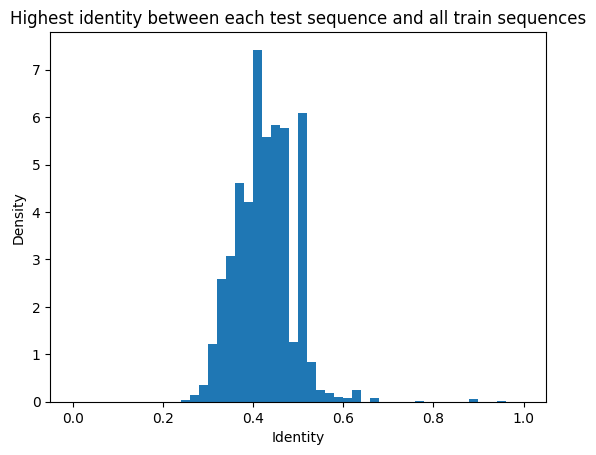

In [10]:
print(f"Max identity: {np.max(test2train_id)}")
print(f"Mean identity: {np.mean(test2train_id)}")
print(f"Median identity: {np.median(test2train_id)}")
print("Quantiles:")
for q in [0.01, 0.05, 0.1, 0.25, 0.5, 0.75, 0.9, 0.95, 0.99]:
    print(f"- {q:.2f} quantile: {np.quantile(test2train_id, q)}")

print("Number of sequences in the training set that are not similar to any test sequence (identity > 0.5):")
print(np.sum(true_train_set))
plt.hist(test2train_id, bins=50, range=(0, 1), density=True)
plt.xlabel("Identity")
plt.ylabel("Density")
plt.title("Highest identity between each test sequence and all train sequences")

Text(0.5, 1.0, 'Pairwise identity distribution between train and test')

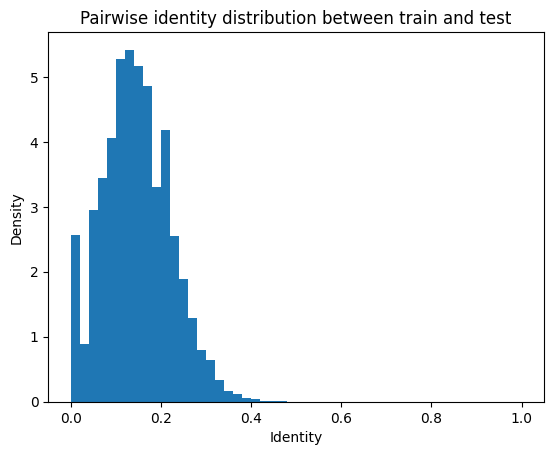

In [11]:
plt.hist(identities.reshape(-1), bins=50, range=(0, 1), density=True)
plt.xlabel("Identity")
plt.ylabel("Density")
plt.title("Pairwise identity distribution between train and test")

In [12]:
print(f"Length of train dataset: {len(train_ids)}")

Length of train dataset: 14297
